In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import chardet
import re
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import warnings
warnings.filterwarnings("ignore", message="The structure of `inputs` doesn't match the expected structure")
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Concatenate, Input, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

pd.options.mode.chained_assignment = None

In [2]:
df_exploded = pd.read_csv('data_output/df_exploded_full.csv')

In [3]:
df_exploded.shape

(1679050, 9)

# Modelo RNN: Prediccion del siguiente golpe del jugador

El objetivo del modelo es tomar como input una seuencia de golpes y un jugador y predecir el siguiente golpe que este jugador dara. 

In [4]:
#Conditional column: where the fourth item in the 'Sequence' column contains 's' new column return 's', when 'b' return 'b', when 'f' return 'f', and when other return 'o'

df_exploded_test = df_exploded[df_exploded['Sequence'].str.split().apply(len) > 3]
df_exploded_test['cuarto'] = df_exploded_test['Sequence'].str.split().str[3].apply(
    lambda x: x[0] if isinstance(x, str) and x[0] in ['s', 'b', 'f'] else 'o'
)
df_exploded_test['cuarto'].value_counts(normalize=True)

f    0.439085
b    0.344230
o    0.119495
s    0.097190
Name: cuarto, dtype: float64

In [5]:
jugador_elegido = "Roger Federer"

df_exploded = df_exploded.dropna(subset=['Sequence'])

df_exploded_filtered = df_exploded[df_exploded['Sequence'].str.split().apply(len) > 3]
# Filter rows where the fourth item in the 'Sequence' column contains 's', 'b', or 'f'
df_exploded_filtered = df_exploded_filtered[
    df_exploded_filtered['Sequence'].str.split().str[3].str.contains(r'^[sbf]')
]

print(f"Total de filas: {df_exploded_filtered.shape[0]}")

Total de filas: 261967


In [6]:
df_exploded_filtered['Sequence'].str.split().str[3].str[0].value_counts(normalize=True)

f    0.498673
b    0.390946
s    0.110380
Name: Sequence, dtype: float64

In [7]:
df_exploded_filtered['X'] = df_exploded_filtered['Sequence'].str.split().str[:3]
df_exploded_filtered['y'] = df_exploded_filtered['Sequence'].str.split().str[3].str[0]

df_exploded_filtered['y'].value_counts(normalize=True)

f    0.498673
b    0.390946
s    0.110380
Name: y, dtype: float64

# Resampling
El mejor desempeño se dio con el siguiente resampling:

In [8]:
#resample df_exploded_filtered so that f = 40% and s = 30% and b = 30%
from sklearn.utils import resample

# Separar las clases
f_class = df_exploded_filtered[df_exploded_filtered['y'] == 'f']
b_class = df_exploded_filtered[df_exploded_filtered['y'] == 'b']
s_class = df_exploded_filtered[df_exploded_filtered['y'] == 's']

# Número total de muestras objetivo
total_samples = len(df_exploded_filtered)

# Calcular el número de muestras para cada clase según las proporciones deseadas
f_target = int(total_samples * 0.49)
b_target = int(total_samples * 0.39)
s_target = int(total_samples * 0.11)

# Aplicar resampling (sobremuestreo o submuestreo)
f_resampled = resample(f_class, replace=True, n_samples=f_target, random_state=42)
b_resampled = resample(b_class, replace=True, n_samples=b_target, random_state=42)
s_resampled = resample(s_class, replace=True, n_samples=s_target, random_state=42)

# Combinar las clases resampleadas
df_resampled = pd.concat([f_resampled, b_resampled, s_resampled])

# Barajar el dataset para mezclar las clases
df_resampled = df_resampled.sample(frac=1, random_state=42).reset_index(drop=True)

df_exploded_filtered = df_resampled.copy() 

In [9]:
df_exploded_filtered[['Player', 'X', 'y']].head()

,Player,X,y
0,Aleksandar Kovacevic,"[f28, s3, f1]",b
1,Jannik Sinner,"[6, b3, f3]",f
2,Xavier Malisse,"[6, b2, b3]",b
3,Andrey Rublev,"[f18, s2, b2]",f
4,Juan Martin Del Potro,"[s28, b2, f1]",b


# Modelo SIN resampling
El modelo previo por alguna razon tenia un f1-score mucho menor que el accuracy, lo cual indica que el modelo estaba prediciendo una clase en particular con mucha frecuencia. Ahora con la 

In [10]:
df_exploded_filtered['y'].value_counts(normalize = True)

f    0.494949
b    0.393941
s    0.111110
Name: y, dtype: float64

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

n_steps = 3

X = df_exploded_filtered['X']
players = df_exploded_filtered['Player']
y = df_exploded_filtered['y']

# Tokenizador para las secuencias
tokenizer = Tokenizer()
tokenizer.fit_on_texts([' '.join(seq) for seq in X])
X_encoded = tokenizer.texts_to_sequences([' '.join(seq) for seq in X])
X_padded = tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=n_steps)

# Codificar jugadores
player_encoder = LabelEncoder()
players_encoded = player_encoder.fit_transform(players)

# Codificar etiquetas (y)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)


In [12]:
"""vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50

# Aumentar la capacidad del modelo
seq_input = Input(shape=(n_steps,), name='sequence_input')
embedding = Embedding(input_dim=vocab_size, output_dim=100)(seq_input)  # Embeddings (vectorizaciones de las secuencias)
lstm = LSTM(128, return_sequences=True)(embedding)  # Red LSTM, unidades y capas adicionales
lstm = LSTM(128)(lstm)
dropout = Dropout(0.3)(lstm)

player_input = Input(shape=(1,), name='player_input')
player_embedding = Embedding(input_dim=len(player_encoder.classes_), output_dim=10)(player_input)  # Embeddings (vectorizacions de jugadores)
player_flattened = tf.keras.layers.Flatten()(player_embedding)

combined = Concatenate()([dropout, player_flattened])
output = Dense(y_categorical.shape[1], activation='softmax', name='output')(combined)

model = Model(inputs=[seq_input, player_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])"""

"vocab_size = len(tokenizer.word_index) + 1\nembedding_dim = 50\n\n# Aumentar la capacidad del modelo\nseq_input = Input(shape=(n_steps,), name='sequence_input')\nembedding = Embedding(input_dim=vocab_size, output_dim=100)(seq_input)  # Embeddings (vectorizaciones de las secuencias)\nlstm = LSTM(128, return_sequences=True)(embedding)  # Red LSTM, unidades y capas adicionales\nlstm = LSTM(128)(lstm)\ndropout = Dropout(0.3)(lstm)\n\nplayer_input = Input(shape=(1,), name='player_input')\nplayer_embedding = Embedding(input_dim=len(player_encoder.classes_), output_dim=10)(player_input)  # Embeddings (vectorizacions de jugadores)\nplayer_flattened = tf.keras.layers.Flatten()(player_embedding)\n\ncombined = Concatenate()([dropout, player_flattened])\noutput = Dense(y_categorical.shape[1], activation='softmax', name='output')(combined)\n\nmodel = Model(inputs=[seq_input, player_input], outputs=output)\nmodel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=

In [13]:
"""from tensorflow.keras.callbacks import EarlyStopping

# Early stopping para evitar overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica que se monitorea
    patience=10,          # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Restaurar los mejores pesos
)

# Dividir en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, players_train, players_test = train_test_split(
    X_padded, y_categorical, players_encoded, test_size=0.2, random_state=42
)

# Entrenar el modelo
history = model.fit(
    [X_train, players_train],
    y_train,
    validation_data=([X_test, players_test], y_test),
    epochs=10,
    batch_size=64,
   # callbacks=[early_stopping]
)
"""

"from tensorflow.keras.callbacks import EarlyStopping\n\n# Early stopping para evitar overfitting\nearly_stopping = EarlyStopping(\n    monitor='val_loss',  # Métrica que se monitorea\n    patience=10,          # Número de épocas sin mejora antes de detener\n    restore_best_weights=True  # Restaurar los mejores pesos\n)\n\n# Dividir en conjuntos de entrenamiento y prueba\nfrom sklearn.model_selection import train_test_split\n\nX_train, X_test, y_train, y_test, players_train, players_test = train_test_split(\n    X_padded, y_categorical, players_encoded, test_size=0.2, random_state=42\n)\n\n# Entrenar el modelo\nhistory = model.fit(\n    [X_train, players_train],\n    y_train,\n    validation_data=([X_test, players_test], y_test),\n    epochs=10,\n    batch_size=64,\n   # callbacks=[early_stopping]\n)\n"

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, players_train, players_test = train_test_split(
    X_padded, y_categorical, players_encoded, test_size=0.2, random_state=42
)

In [15]:
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

"""vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50

def build_model(hp):
    # Hiperparámetros a optimizar
    lstm_units = hp.Choice('lstm_units', [64, 128, 256])  # Tamaño de las capas LSTM
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.5, step=0.1)  # Dropout entre 0.2 y 0.5
    learning_rate = hp.Choice('learning_rate', [0.0001, 0.0005, 0.001, 0.005])  # Learning rates
    
    # Modelo
    seq_input = Input(shape=(n_steps,), name='sequence_input')
    embedding = Embedding(input_dim=vocab_size, output_dim=100)(seq_input)
    lstm = LSTM(lstm_units, return_sequences=True)(embedding)
    lstm = LSTM(lstm_units)(lstm)
    dropout = Dropout(dropout_rate)(lstm)
    
    player_input = Input(shape=(1,), name='player_input')
    player_embedding = Embedding(input_dim=len(player_encoder.classes_), output_dim=10)(player_input)
    player_flattened = tf.keras.layers.Flatten()(player_embedding)
    
    combined = Concatenate()([dropout, player_flattened])
    output = Dense(y_categorical.shape[1], activation='softmax', name='output')(combined)
    
    model = Model(inputs=[seq_input, player_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Crear un tuner para buscar los mejores hiperparámetros
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='kt_tuning',
    project_name='rnn_tuning'
)

# Ejecutar la búsqueda
tuner.search([X_train, players_train], y_train, 
             validation_data=([X_test, players_test], y_test), 
             epochs=10, batch_size=64)

# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")
"""

'vocab_size = len(tokenizer.word_index) + 1\nembedding_dim = 50\n\ndef build_model(hp):\n    # Hiperparámetros a optimizar\n    lstm_units = hp.Choice(\'lstm_units\', [64, 128, 256])  # Tamaño de las capas LSTM\n    dropout_rate = hp.Float(\'dropout_rate\', 0.2, 0.5, step=0.1)  # Dropout entre 0.2 y 0.5\n    learning_rate = hp.Choice(\'learning_rate\', [0.0001, 0.0005, 0.001, 0.005])  # Learning rates\n    \n    # Modelo\n    seq_input = Input(shape=(n_steps,), name=\'sequence_input\')\n    embedding = Embedding(input_dim=vocab_size, output_dim=100)(seq_input)\n    lstm = LSTM(lstm_units, return_sequences=True)(embedding)\n    lstm = LSTM(lstm_units)(lstm)\n    dropout = Dropout(dropout_rate)(lstm)\n    \n    player_input = Input(shape=(1,), name=\'player_input\')\n    player_embedding = Embedding(input_dim=len(player_encoder.classes_), output_dim=10)(player_input)\n    player_flattened = tf.keras.layers.Flatten()(player_embedding)\n    \n    combined = Concatenate()([dropout, player_f

In [16]:
"""best_model = tuner.hypermodel.build(best_hps)

# Entrenar el modelo con los datos
history = best_model.fit(
    [X_train, players_train], y_train,
    validation_data=([X_test, players_test], y_test),
    epochs=20,  # Puedes ajustar este valor si es necesario
    batch_size=64
)"""

'best_model = tuner.hypermodel.build(best_hps)\n\n# Entrenar el modelo con los datos\nhistory = best_model.fit(\n    [X_train, players_train], y_train,\n    validation_data=([X_test, players_test], y_test),\n    epochs=20,  # Puedes ajustar este valor si es necesario\n    batch_size=64\n)'

In [17]:
Best_hyperparameters = {'lstm_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0015'}

# Create and train model with dict "Best_hyperparameters"
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50

seq_input = Input(shape=(n_steps,), name='sequence_input')
embedding = Embedding(input_dim=vocab_size, output_dim=100)(seq_input)
lstm = LSTM(256, return_sequences=True)(embedding)
lstm = LSTM(256)(lstm)
dropout = Dropout(0.2)(lstm)

player_input = Input(shape=(1,), name='player_input')
player_embedding = Embedding(input_dim=len(player_encoder.classes_), output_dim=10)(player_input)
player_flattened = tf.keras.layers.Flatten()(player_embedding)

combined = Concatenate()([dropout, player_flattened])
output = Dense(y_categorical.shape[1], activation='softmax', name='output')(combined)

best_model = Model(inputs=[seq_input, player_input], outputs=output)
best_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
# Entrenar el modelo
history = best_model.fit(
    [X_train, players_train],
    y_train,
    validation_data=([X_test, players_test], y_test),
    epochs=10,
    batch_size=64,
    # callbacks=[early_stopping]
)

Epoch 1/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.5150 - loss: 0.9315 - val_accuracy: 0.5369 - val_loss: 0.9079
Epoch 2/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.5328 - loss: 0.9072 - val_accuracy: 0.5344 - val_loss: 0.9069
Epoch 3/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.5340 - loss: 0.9047 - val_accuracy: 0.5349 - val_loss: 0.9071
Epoch 4/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.5389 - loss: 0.9011 - val_accuracy: 0.5360 - val_loss: 0.9048
Epoch 5/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.5384 - loss: 0.9019 - val_accuracy: 0.5376 - val_loss: 0.9052
Epoch 6/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.5383 - loss: 0.9017 - val_accuracy: 0.5347 - val_loss: 0.9054
Epoch 7/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.5391 - loss: 0.8996 - val_accuracy: 0.5365 - val_loss: 0.9041
Epoch 8/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.5388 -

In [19]:
# Predecir el próximo golpe
def predict_next_shot(sequence, player):
    # Preprocesar entrada
    seq_encoded = tokenizer.texts_to_sequences([sequence])
    seq_padded = tf.keras.preprocessing.sequence.pad_sequences(seq_encoded, maxlen=n_steps)
    player_encoded = player_encoder.transform([player])
    
    # Hacer predicción
    prediction = best_model.predict([seq_padded, player_encoded])[0]  # Vector de probabilidades para la fila
    
    # Mapear índices a las clases
    class_probabilities = {label_encoder.inverse_transform([i])[0]: prob for i, prob in enumerate(prediction)}
    return class_probabilities

# Evaluar en el conjunto de prueba
loss, accuracy = best_model.evaluate([X_test, players_test], y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

1621/1621 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5418 - loss: 0.9034
Test Loss: 0.9030194282531738, Test Accuracy: 0.541777491569519


In [21]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Calcular y mostrar métricas
y_pred = best_model.predict([X_test, players_test])
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

#calculate ROC AUC
from sklearn.metrics import roc_auc_score

# Calculate ROC AUC score for multi-class classification
roc_auc = roc_auc_score(y_true_classes, y_pred, multi_class='ovr')
print(f"ROC AUC: {roc_auc:.2f}")


1621/1621 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Test Loss: 0.90
Test Accuracy: 0.54
Precision: 0.53
Recall: 0.54
F1-Score: 0.51
ROC AUC: 0.66


In [64]:
secuencia = ['b1', 'b3', 'f3']

print(predict_next_shot(secuencia, "Roger Federer"))
print(predict_next_shot(secuencia, "Novak Djokovic"))
print(predict_next_shot(secuencia, "Rafael Nadal"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
{'b': 0.34836102, 'f': 0.47610682, 's': 0.1755321}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
{'b': 0.4657231, 'f': 0.45734632, 's': 0.07693064}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
{'b': 0.4159245, 'f': 0.48010632, 's': 0.1039691}


# Evaluación del modelo: Metricas

6484/6484 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


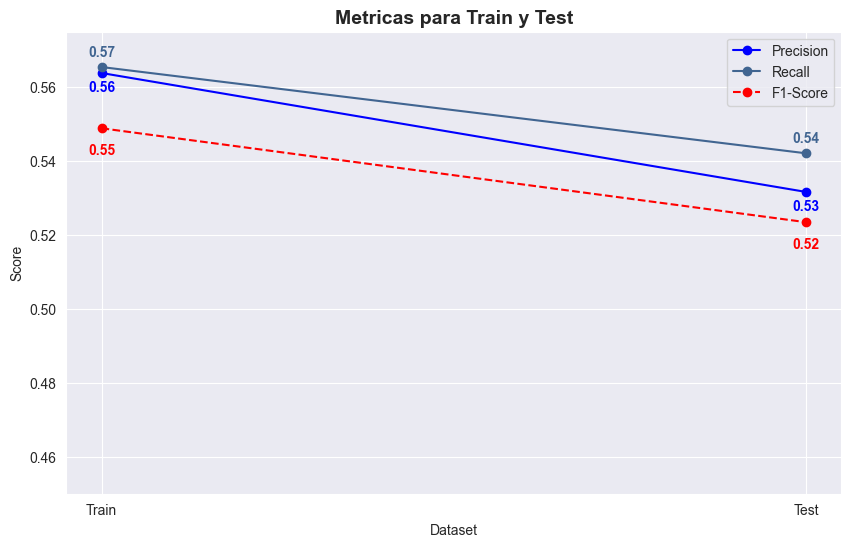

,Dataset,Precision,Recall,F1-Score,Overfitting_Evaluation
0,Train,0.563829,0.565449,0.548880,0.000000
1,Test,0.531652,0.542105,0.523465,0.025415


In [65]:
# Calcular métricas para el conjunto de entrenamiento
y_train_pred = best_model.predict([X_train, players_train])
y_train_pred_classes = y_train_pred.argmax(axis=1)
y_train_true_classes = y_train.argmax(axis=1)

train_precision = precision_score(y_train_true_classes, y_train_pred_classes, average='weighted')
train_recall = recall_score(y_train_true_classes, y_train_pred_classes, average='weighted')
train_f1 = f1_score(y_train_true_classes, y_train_pred_classes, average='weighted')

# Crear un DataFrame para mostrar las métricas
metrics_df = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Precision': [train_precision, precision],
    'Recall': [train_recall, recall],
    'F1-Score': [train_f1, f1]
})

# Evaluar el overfitting comparando las métricas entre train y test
metrics_df['Overfitting_Evaluation'] = metrics_df['F1-Score'].diff().fillna(0).abs()

# Visualizar las métricas en una tabla

# Visualizar las métricas en un plot, con linea entre train y test
plt.figure(figsize=(10, 6))
plt.plot(['Train', 'Test'], metrics_df['Precision'], label='Precision', marker='o', color = 'blue')
plt.plot(['Train', 'Test'], metrics_df['Recall'], label='Recall', marker='o',  color = '#416591')
plt.plot(['Train', 'Test'], metrics_df['F1-Score'], label='F1-Score', marker='o',  color = 'red', linestyle='--')

for i, (precision, recall, f1) in enumerate(zip(metrics_df['Precision'], metrics_df['Recall'], metrics_df['F1-Score'])):
    plt.text(i, precision - 0.005, f"{precision:.2f}", ha='center', fontsize=10, color='blue', fontweight='bold')
    plt.text(i, recall + 0.003, f"{recall:.2f}", ha='center', fontsize=10, color='#416591', fontweight='bold')
    plt.text(i, f1 - 0.007, f"{f1:.2f}", ha='center', fontsize=10, color='red', fontweight='bold')

plt.title("Metricas para Train y Test", fontsize=14, fontweight='bold')
plt.xlabel("Dataset")
plt.ylabel("Score")
plt.ylim(0.45, 0.575)
plt.legend()
plt.grid(True)

plt.savefig('viz_outputs/metricas_RNN.png')
plt.show()

metrics_df


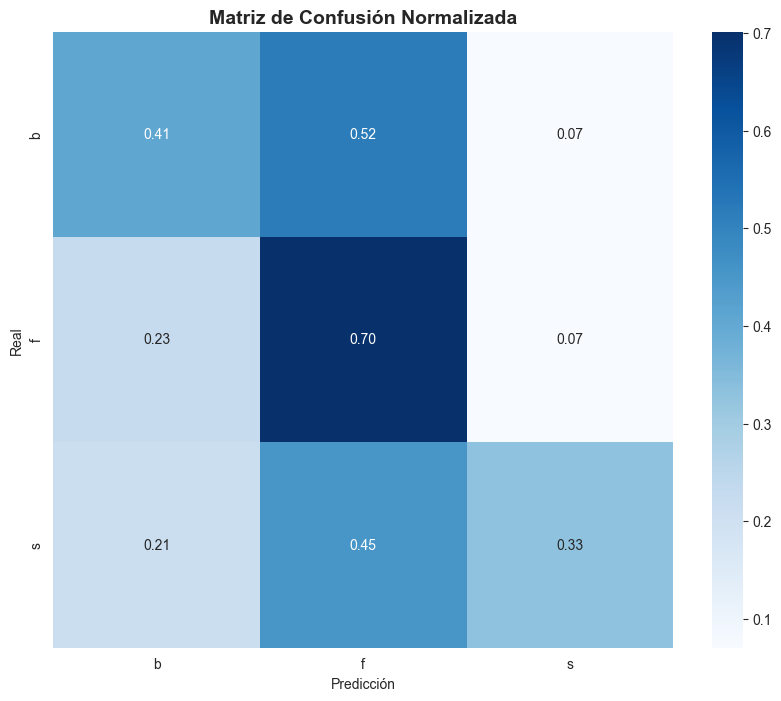

In [75]:
#Make confusion matrix in percentages
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matriz de Confusión Normalizada", fontsize=14, fontweight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.savefig('viz_outputs/confusion_matrix_RNN_test.png')
plt.show()


El modelo podría tener mejor accuracy, pero tiene un buen desempeño dando predicciones coherentes con los estilos de juego de los jugadores. Por ejemplo, Federer de Reves a una mano tiene mas propension a dar un slice que otros jugadores y esto es reflejado en las predicciones del modelo. 
También una sucesión de golpes simples al medio son seguidos por altas probabilidades de un reves, lo cual tiene sentido porque la mayoría de los rivales prefieren forzar que el jugador de un reves.

In [68]:
#resample target and train model
from sklearn.utils import resample

# Separar las clases
f_class = df_exploded_filtered[df_exploded_filtered['y'] == 'f']
b_class = df_exploded_filtered[df_exploded_filtered['y'] == 'b']
s_class = df_exploded_filtered[df_exploded_filtered['y'] == 's']

# Número total de muestras objetivo
total_samples = len(df_exploded_filtered)

# Calcular el número de muestras para cada clase según las proporciones deseadas
f_target = int(total_samples * 0.45)
b_target = int(total_samples * 0.35)
s_target = int(total_samples * 0.20)

# Aplicar resampling (sobremuestreo o submuestreo)
f_resampled = resample(f_class, replace=True, n_samples=f_target, random_state=42)
b_resampled = resample(b_class, replace=True, n_samples=b_target, random_state=42)
s_resampled = resample(s_class, replace=True, n_samples=s_target, random_state=42)

# Combinar las clases resampleadas
df_resampled = pd.concat([f_resampled, b_resampled, s_resampled])

# Barajar el dataset para mezclar las clases
df_resampled = df_resampled.sample(frac=1, random_state=42).reset_index(drop=True)

df_exploded_filtered_resampled = df_resampled.copy()


In [71]:

n_steps = 3

X = df_exploded_filtered_resampled['X']
players = df_exploded_filtered_resampled['Player']
y = df_exploded_filtered_resampled['y']

# Tokenizador para las secuencias
tokenizer = Tokenizer()
tokenizer.fit_on_texts([' '.join(seq) for seq in X])
X_encoded = tokenizer.texts_to_sequences([' '.join(seq) for seq in X])
X_padded = tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=n_steps)

# Codificar jugadores
player_encoder = LabelEncoder()
players_encoded = player_encoder.fit_transform(players)

# Codificar etiquetas (y)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)


In [72]:

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test, players_train, players_test = train_test_split(
    X_padded, y_categorical, players_encoded, test_size=0.2, random_state=42
)

# Entrenar el modelo
history = best_model.fit(
    [X_train, players_train],
    y_train,
    validation_data=([X_test, players_test], y_test),
    epochs=10,
    batch_size=64,
   # callbacks=[early_stopping]
)


Epoch 1/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.5034 - loss: 0.9932 - val_accuracy: 0.5174 - val_loss: 0.9517
Epoch 2/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.5241 - loss: 0.9409 - val_accuracy: 0.5224 - val_loss: 0.9450
Epoch 3/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.5320 - loss: 0.9290 - val_accuracy: 0.5243 - val_loss: 0.9431
Epoch 4/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.5376 - loss: 0.9207 - val_accuracy: 0.5237 - val_loss: 0.9416
Epoch 5/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.5382 - loss: 0.9184 - val_accuracy: 0.5261 - val_loss: 0.9410
Epoch 6/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.5406 - loss: 0.9130 - val_accuracy: 0.5246 - val_loss: 0.9427
Epoch 7/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.5409 - loss: 0.9124 - val_accuracy: 0.5269 - val_loss: 0.9412
Epoch 8/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.5423 -

In [73]:
#predict with new model and make confusion matrix
y_pred = best_model.predict([X_test, players_test])
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


1621/1621 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Test Loss: 0.91
Test Accuracy: 0.54
Precision: 0.52
Recall: 0.53
F1-Score: 0.51


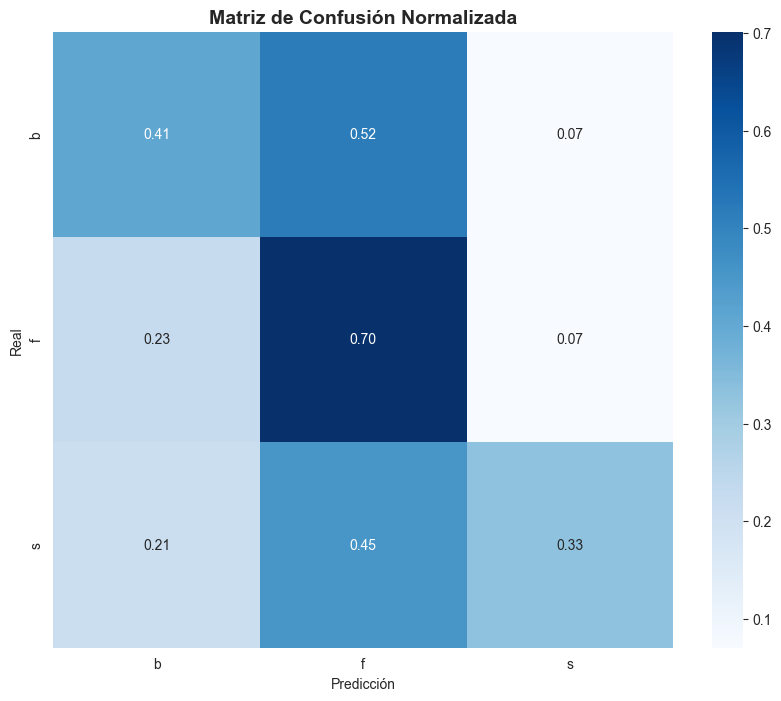

In [74]:
# confusion matrix in percentages
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
    
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matriz de Confusión Normalizada", fontsize=14, fontweight='bold')
plt.xlabel("Predicción")
plt.ylabel("Real")
#plt.savefig('viz_outputs/confusion_matrix_RNN_resampled.png')
plt.show()

